In [1]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

from sklearn.metrics import f1_score
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
NUM_CLASSES = 4
MAX_LEN = 100
BATCH = 16
PRE_TRAINED_MODEL_NAME = "distilbert-base-uncased" #'bert-base-cased'
EPOCHS = 50
LEARNING_RATE = 0.001
THRESHOLD = 0.2
DROPOUT_RATE = 0.5
WEIGHT_DECAY = 0.0001
MODE = 'min'
PATIENCE = 2
FACTOR = 0.5
VERBOSE = True

In [3]:
df = pd.read_csv('D:/julixus/MEISD/meisd_project/data/MEISD_text.csv')
# Zamień wartości na liczby całkowite
df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce').fillna(0)
df['intensity2'] = pd.to_numeric(df['intensity2'], errors='coerce').fillna(0)
df['intensity3'] = pd.to_numeric(df['intensity3'], errors='coerce').fillna(0)

# Zamień wartości zawierające tylko białe znaki lub '`', 'neu', 'po' na NaN
df['intensity'] = df['intensity'].replace(r'^\s*$', np.nan, regex=True)
df['intensity'] = df['intensity'].replace(['`', 'neu', 'po'], np.nan)
df['intensity2'] = df['intensity2'].replace(r'^\s*$', np.nan, regex=True)
df['intensity2'] = df['intensity2'].replace(['`', 'neu', 'po'], np.nan)
df['intensity3'] = df['intensity3'].replace(r'^\s*$', np.nan, regex=True)
df['intensity3'] = df['intensity3'].replace(['`', 'neu', 'po'], np.nan)

# Użyj forward fill, aby uzupełnić brakujące wartości poprzedzającą wartością
df['intensity'] = df['intensity'].ffill()
df['intensity2'] = df['intensity2'].ffill()
df['intensity3'] = df['intensity3'].ffill()

# Usuń znaki niebędące cyframi (np. '`') za pomocą wyrażeń regularnych
df['intensity'] = df['intensity'].replace(r'\D', '', regex=True).astype(int)  # Usuwa wszystko, co nie jest cyfrą
df['intensity2'] = df['intensity2'].replace(r'\D', '', regex=True).astype(int)
df['intensity3'] = df['intensity3'].replace(r'\D', '', regex=True).astype(int)

missing_count = df['intensity'].isna().sum()
print(f"Liczba braków w kolumnie 'intensity': {missing_count}")
unique_values = df['intensity'].unique()
print(f"Unikalne wartości w kolumnie 'intensity': {unique_values}")

Liczba braków w kolumnie 'intensity': 0
Unikalne wartości w kolumnie 'intensity': [0 1 2 3]


In [4]:
columns = ['Utterances', 'dialog_ids', 'uttr_ids', 'intensity', 'intensity2', 'intensity3']
df = df[columns].copy()

In [5]:
first_25_data = []
last_25_data = []

def process_group(group):
    num_rows = len(group)
    quarter_size = max(1, num_rows // 4)

    # First 25%
    first_25 = group.iloc[:quarter_size]
    primary_intensity = max(
        group['intensity'].iloc[0],
        group['intensity2'].iloc[0],
        group['intensity3'].iloc[0]
    )
    first_25 = first_25.assign(primary_intensity=primary_intensity)

    # Last 25%
    last_25 = group.iloc[-quarter_size:]
    final_intensity = max(
        group['intensity'].iloc[-1],
        group['intensity2'].iloc[-1],
        group['intensity3'].iloc[-1]
    )
    last_25 = last_25.assign(final_intensity=final_intensity)

    first_25_data.append(first_25)
    last_25_data.append(last_25)

df.groupby('dialog_ids').apply(process_group)

first_25_df = pd.concat(first_25_data).reset_index(drop=True)
last_25_df = pd.concat(last_25_data).reset_index(drop=True)

grouped_first_25 = first_25_df.groupby('dialog_ids').agg({
    'Utterances': ' '.join,
    'primary_intensity': 'first'
}).reset_index()

grouped_last_25 = last_25_df.groupby('dialog_ids').agg({
    'Utterances': ' '.join,
    'final_intensity': 'first'
}).reset_index()

df = grouped_first_25.drop(df.columns[0], axis=1)

# grouped_first_25.to_csv('first_25_percent.csv', index=False)
# grouped_last_25.to_csv('last_25_percent.csv', index=False)

C:\Users\Julix\AppData\Local\Temp\ipykernel_14860\2868896721.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('dialog_ids').apply(process_group)


In [6]:
grouped_first_25.head()

,dialog_ids,Utterances,primary_intensity
0,1,look around you say hello to your competition ...,0
1,2,"i'm george o'malley uh, we met at the mixer. y...",2
2,3,seattle is surrounded by water on three sides ...,1
3,4,yes no other reason? just a favor for an old p...,1
4,5,if he doesn't respond to these tests in the ne...,2


In [7]:
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
# 
# # Test the tokenizer
# test_text = "We are testing BERT tokenizer."
# # generate encodings
# encodings = tokenizer.encode_plus(test_text,
#                                   add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                                   max_length = 50,
#                                   truncation = True,
#                                   padding = "max_length",
#                                   return_attention_mask = True,
#                                   return_tensors = "pt")

In [8]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer

# Jeśli używasz DistilBERT, musisz załadować tokenizer dla DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(
    test_text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=50,
    truncation=True,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
)

print("Input IDs:", encodings["input_ids"])
print("Attention Mask:", encodings["attention_mask"])


Input IDs: tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [9]:
grouped_last_25.head()

,dialog_ids,Utterances,final_intensity
0,1,"you're cristina, right? - patton, monroe which...",2
1,2,i have five rules. memorize them rule number o...,0
2,3,"""i'm your sister, i'm your daughter."" you're s...",0
3,4,just be quick about it you're the one that's s...,3
4,5,people do wake up. that's why we do a series o...,1


In [10]:
token_lens = []

for txt in grouped_first_25['Utterances']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))


C:\Users\Julix\AppData\Local\Temp\ipykernel_14860\1466372787.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

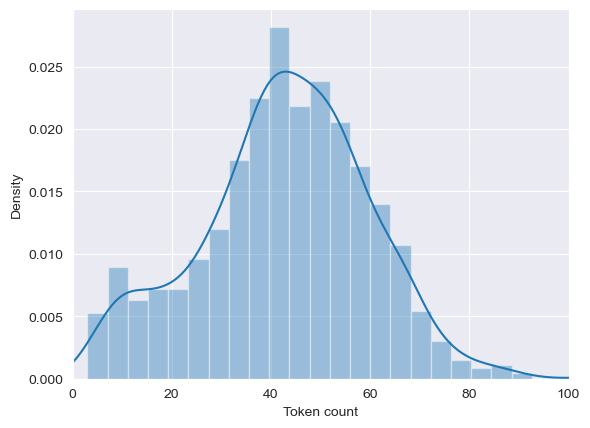

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')

In [12]:
df = grouped_first_25

In [13]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df['primary_intensity'].astype(int).values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long),
            'utterances': utterances
        }


In [14]:
from sklearn.model_selection import train_test_split

# split into train and test
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [15]:
print(f"Original train size: {df.shape}")
print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

Original train size: (1124, 3)
Validation size: (169, 3), Test size: (169, 3)


In [16]:
label_frequencies = df_train['primary_intensity'].value_counts()
label_frequencies_percent = df_train['primary_intensity'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

primary_intensity
2    36.259542
1    25.954198
3    24.045802
0    13.740458
Name: proportion, dtype: float64
primary_intensity
2    285
1    204
3    189
0    108
Name: count, dtype: int64


In [17]:
target_list = list(df.columns)
target_list = target_list[1:]
target_list

['Utterances', 'primary_intensity']

In [18]:
# class BERT_IntensityClass(torch.nn.Module):
#     def __init__(self, bert_model):
#         super(BERT_IntensityClass, self).__init__()
#         self.bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)
#         self.dropout = torch.nn.Dropout(p=DROPOUT_RATE) #0.5
#         self.linear = torch.nn.Linear(bert_model.config.hidden_size, NUM_CLASSES)
#         #self.softmax = nn.Softmax(dim=1) #remove for sentiment analysis
#         #CrossEntropyLoss automatycznie aplikuje funkcję softmax, więc nie ma potrzeby używać Softmax w modelu.
# 
# 
#     def forward(self, input_ids, attn_mask, token_type_ids=None):
#         output = self.bert_model(input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids)
#         #pooler_output = self.pooler_output
#         dropout_output = self.dropout(output.pooler_output)
#         linear_output = self.linear(dropout_output)
#         #output = self.dropout(linear_output)
#         # output = self.softmax(linear_output)
#         return linear_output

In [19]:
class DistilBERT_IntensityClass(torch.nn.Module):
    def __init__(self, distilbert_model, dropout_rate=DROPOUT_RATE, num_classes=NUM_CLASSES):
        super(DistilBERT_IntensityClass, self).__init__()
        self.distilbert_model = distilbert_model
        self.dropout = torch.nn.Dropout(p=DROPOUT_RATE)
        self.linear = torch.nn.Linear(self.distilbert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attn_mask):
        # DistilBERT model processing
        output = self.distilbert_model(input_ids, attention_mask=attn_mask)

        # Use the last hidden state (the embedding for [CLS] token is at index 0)
        cls_output = output.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]
        # Apply dropout
        dropout_output = self.dropout(cls_output)
        # Get final class logits
        linear_output = self.linear(dropout_output)
        return linear_output


In [20]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# model = BERT_IntensityClass(bert_model)
# model.to(device)
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [21]:
from transformers import DistilBertModel
distilbert_model = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = DistilBERT_IntensityClass(distilbert_model)
model.to(device)
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [22]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [23]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

In [24]:
# data = next(iter(train_data_loader))
# outputs = model(data["input_ids"], attn_mask=data["attention_mask"])
# print(outputs)

In [25]:
data = next(iter(train_data_loader))

In [26]:
# test_text = "We are testing BERT tokenizer."
# encodings = tokenizer.encode_plus(test_text,
#                                   add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
#                                   max_length=50,
#                                   truncation=True,
#                                   padding="max_length",
#                                   return_attention_mask=True,
#                                   return_tensors="pt")


In [27]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer

# Jeśli używasz DistilBERT, musisz załadować tokenizer dla DistilBERT

test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(
    test_text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=50,
    truncation=True,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
)

print("Input IDs:", encodings["input_ids"])
print("Attention Mask:", encodings["attention_mask"])


Input IDs: tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [28]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# last_hidden_state, pooled_output = bert_model(
#     input_ids=encodings['input_ids'],
#     attention_mask=encodings['attention_mask']
# )

In [29]:
# Pass the inputs through the DistilBERT model
output = distilbert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)

# Extract the last hidden state
last_hidden_state = output.last_hidden_state

# Extract the representation of the [CLS] token (first token in the sequence)
cls_output = last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]

# Now you can use cls_output for downstream tasks (e.g., classification)


In [30]:
class_distribution = df_train['primary_intensity'].value_counts(normalize=True)
total_samples = sum(class_distribution)
class_weights = [total_samples / count for count in class_distribution]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([2.7579, 3.8529, 4.1587, 7.2778])

In [31]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)

In [32]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs')

In [33]:
from transformers import AdamW, get_linear_schedule_with_warmup

#EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE, patience=PATIENCE, factor=FACTOR, verbose=VERBOSE)

D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)


# Forward pass
        outputs = model(ids, mask)

        # Calculate loss
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        # Collect predictions and labels for F1-score
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        loop.set_postfix(batch_loss=loss.item())

    # Calculate F1-score for training data
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return model, correct_predictions / num_samples, np.mean(losses), train_f1

In [35]:
def eval_model(validation_loader, model, epoch):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(ids, mask)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Calculate predictions and accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Logowanie do TensorBoard
    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1

In [36]:
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import io

history = defaultdict(list)
best_accuracy = 0
writer = SummaryWriter(log_dir='logs')

def plot_confusion_matrix(cm, class_names, epoch):
    figure = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix at Epoch {epoch}')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = torch.tensor(np.frombuffer(buf.getvalue(), dtype=np.uint8)).float()
    writer.add_image('Confusion Matrix', image, epoch)

    plt.close(figure)  

In [ ]:
# Główna pętla treningowa
# %%time
history = defaultdict(list)
best_f1 = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss, train_f1 = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(val_data_loader, model, epoch)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')

    # Logowanie metryk do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('F1-Score/train', train_f1, epoch)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # Sprawdzenie najlepszej F1 i zapisanie modelu
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_f1 = val_f1
        print("Saved new best model.")

    scheduler.step(val_loss)  # Tuning LR

writer.close()

Epoch 1/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.4359 | Train accuracy 0.3219 | Train F1 0.2933
Val loss 1.2763 | Val accuracy 0.3077 | Val F1 0.1448
Saved new best model.
Epoch 2/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3141 | Train accuracy 0.2875 | Train F1 0.2433
Val loss 1.2482 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 3/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3040 | Train accuracy 0.2964 | Train F1 0.2337
Val loss 1.2883 | Val accuracy 0.3077 | Val F1 0.1448
Epoch 4/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.3001 | Train accuracy 0.2557 | Train F1 0.2022
Val loss 1.2522 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 5/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2856 | Train accuracy 0.2672 | Train F1 0.1892
Val loss 1.2573 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 6/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2889 | Train accuracy 0.2672 | Train F1 0.2012
Val loss 1.2512 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 7/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2903 | Train accuracy 0.2990 | Train F1 0.2257
Val loss 1.2598 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 8/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2788 | Train accuracy 0.2519 | Train F1 0.1572
Val loss 1.2680 | Val accuracy 0.3077 | Val F1 0.1448
Epoch 9/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2922 | Train accuracy 0.3003 | Train F1 0.2276
Val loss 1.2483 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 10/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2762 | Train accuracy 0.2761 | Train F1 0.1943
Val loss 1.2480 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 11/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2902 | Train accuracy 0.2786 | Train F1 0.2011
Val loss 1.2512 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 12/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2828 | Train accuracy 0.2621 | Train F1 0.1835
Val loss 1.2511 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 13/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2771 | Train accuracy 0.2608 | Train F1 0.1909
Val loss 1.2500 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 14/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2790 | Train accuracy 0.2608 | Train F1 0.1721
Val loss 1.2525 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 15/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2741 | Train accuracy 0.2964 | Train F1 0.2256
Val loss 1.2525 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 16/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2805 | Train accuracy 0.2926 | Train F1 0.2208
Val loss 1.2502 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 17/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2695 | Train accuracy 0.2595 | Train F1 0.1515
Val loss 1.2483 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 18/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2957 | Train accuracy 0.2379 | Train F1 0.1337
Val loss 1.2486 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 19/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2896 | Train accuracy 0.2468 | Train F1 0.1544
Val loss 1.2484 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 20/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2735 | Train accuracy 0.2532 | Train F1 0.1500
Val loss 1.2501 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 21/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2724 | Train accuracy 0.2646 | Train F1 0.1761
Val loss 1.2507 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 22/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2740 | Train accuracy 0.2723 | Train F1 0.1919
Val loss 1.2515 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 23/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2761 | Train accuracy 0.2506 | Train F1 0.1710
Val loss 1.2512 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 24/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2832 | Train accuracy 0.2748 | Train F1 0.1939
Val loss 1.2505 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 25/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2831 | Train accuracy 0.2557 | Train F1 0.1616
Val loss 1.2500 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 26/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2739 | Train accuracy 0.2735 | Train F1 0.1811
Val loss 1.2503 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 27/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2762 | Train accuracy 0.2455 | Train F1 0.1479
Val loss 1.2503 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 28/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2841 | Train accuracy 0.2570 | Train F1 0.1620
Val loss 1.2500 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 29/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2926 | Train accuracy 0.2723 | Train F1 0.1782
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 30/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2834 | Train accuracy 0.2481 | Train F1 0.1562
Val loss 1.2503 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 31/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2741 | Train accuracy 0.2570 | Train F1 0.1680
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 32/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2776 | Train accuracy 0.2405 | Train F1 0.1532
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 33/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2691 | Train accuracy 0.2621 | Train F1 0.1582
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 34/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2790 | Train accuracy 0.2545 | Train F1 0.1653
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 35/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2803 | Train accuracy 0.2443 | Train F1 0.1551
Val loss 1.2505 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 36/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2761 | Train accuracy 0.2710 | Train F1 0.1757
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 37/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2772 | Train accuracy 0.2684 | Train F1 0.1784
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 38/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2747 | Train accuracy 0.2913 | Train F1 0.2009
Val loss 1.2504 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 39/50


  0%|          | 0/50 [00:00<?, ?it/s]

Train loss 1.2890 | Train accuracy 0.2608 | Train F1 0.1783
Val loss 1.2505 | Val accuracy 0.2781 | Val F1 0.1210
Epoch 40/50


  0%|          | 0/50 [00:00<?, ?it/s]